# Experiment Setup using Synthetic Data

## Research Question 
Can a simple feed forward network, trained with a gaussian-weighted loss function focused on ATM can outperform baseline MSE models for short dated ATM options 

## Notebook Outline 
1. Generate synthetic blackscholes training data using sobol sequence sampling over (M,T,sigma)
2. Train a baseline model on synthtic data and IV mapping from yfinance
3. Train a Gaussian Weighted Loss: 
    - Check overall error
    - ATM Error 
4. Check on Real Data (SPY Option Chain)
    - clean the stale quotes 
    - fit implied volatility surface 
    - Checks for Model (non-negativity, Smile, Skew, Calendar variance monocity)
5. Report runtime speed and gradient stability

## Key defination 
- Log-moneyness $M = ln(S/K)$
- time to expiry $T$ in years 
- Implied Volatitlity: $\sigma_{impl}$


## Hypothesis
Weighted loss will improve accuracy in regions that matter most for trading/hedging (ATM/near-term),
at the cost of slightly worse fit in far OTM/long-dated regions

In [120]:
import pandas as pd
import numpy as np
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance
import datetime
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Dependencies
Reproducibility notes:
- Random seeds are set where relevant (Sobol seed, torch seed).
- Real-data results depend on the market snapshot time when yfinance is queried.


## Problem Setup and Learning Objective

### Synthetic setting (primary experiment)
We study European option pricing under the Black–Scholes model and train a neural network to learn the **normalized option price**
$\frac{C}{K} = f(M, T, \sigma)$
where:
- $M = \ln(S/K)$ is log-moneyness,
- $T$ is time to maturity (years),
- $\sigma$ is volatility.

Using the homogeneity of Black–Scholes, pricing in units of the strike removes scale dependence and improves numerical stability.

### Learning task
Given inputs:
$x = (M, T, \sigma)$

learn a smooth function approximator for strike normalized price $C/K$

### Input domain
The synthetic data spans a broad but realistic option surface:
- $M \in [-1.5, 1.5]$
- $T \in [0.01, 2.0]$ years
- $\sigma \in [0.05, 0.90]$
- Risk-free rate $r$ is fixed initially

### Sampling strategy
We use **Sobol low-discrepancy sequences** instead of IID Monte Carlo sampling to:
- ensure uniform coverage of the domain,
- reduce clustering,
- improve convergence of the neural network for a fixed sample size.

Time is sampled uniformly in $\sqrt{T}$  then squared to increase samples near short maturities, which are most sensitive in option pricing. Log(S/K) moneyness is sampled directly to have a uniform sample accross moneyness 


__________________

#### Rationale 
Although long-dated options exist, the option market is structurally and economically dominated by short-dated contracts, motivating sampling and loss weighting schemes that emphasize small Time to maurity. $𝑇$

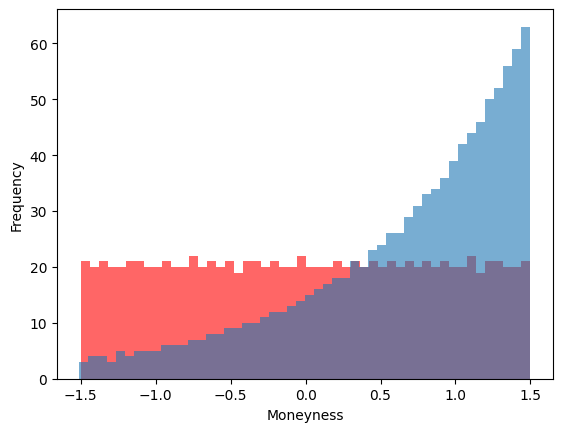

In [121]:
## log(S/K) sample vs S/K sample then taking log
## we are using uniform sampling for log(s/k) to avoid non-meaningful 
sampler = qmc.Sobol(d=1, scramble=True, seed=42)
sample = sampler.random_base2(m=10)
log_sk = qmc.scale(sample, -1.5, 1.5)
sk = qmc.scale(sample, 0.22, 4.48) 
sk = np.log(sk)

# plt
plt.hist(log_sk, bins=50, alpha=0.6, color='red', label='Sample LOG(S/K) directly')
plt.hist(sk, bins=50, alpha=0.6, label='Sample S/K then log(S/K)')
plt.xlabel("Moneyness")
plt.ylabel("Frequency")
plt.show()


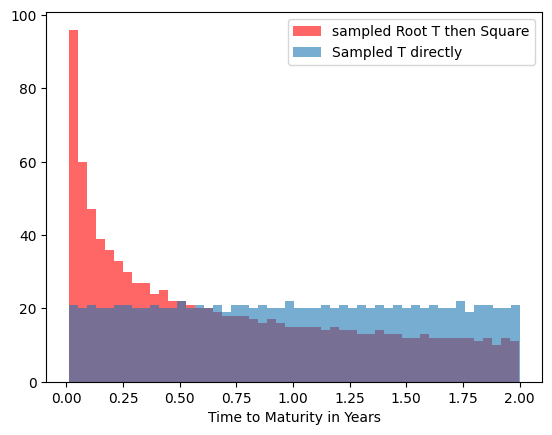

In [122]:
# sampling T and then taking root vs sampling root T and then applying sqaure
# this method increases the sampling for short dated maturities
sampler = qmc.Sobol(d=1, scramble=True, seed=42)
sample = sampler.random_base2(m=10)
l_roott = np.sqrt(0.01)
u_roott = np.sqrt(2)
troot = qmc.scale(sample, l_roott, u_roott)
t = qmc.scale(sample, 0.01, 2)
T = troot**2

# plt 
plt.hist(T, bins=50, alpha=0.6, color='red', label='sampled Root T then Square')
plt.hist(t, bins=50, alpha=0.6, label='Sampled T directly')
plt.xlabel("Time to Maturity in Years")
plt.ylabel("")
plt.legend()
plt.show()

## Synthetic Data Genration using closed form BlackScholes 

We are using sobol sequence to generate uniform samples whcih can be used to create data samples using closed form blackscholes for the supervise learning problem

- **Input** $X \in (M, T, \sigma)$
- **Target** $y = C/K$ (option price normalized by the strike)


##### Components:

1. `BlackScholesPricer`: analytical BS pricing 
2. `LogMoneynessPricer`: this enforce homogenity by K = 1 and setting up $S=\exp(M)$
3. `SobolSampler`: it generates uniform low-descrepency samples over $x \in (M, \sqrt{T}, \sigma)$
4. `BSDataGenerator`:  converts the data into X and y for training 

In [123]:
# blackscholes implementation 
class BlackScholesPricer: 
    def __init__(self, r: float):
        self.r = r                                            # since r is a model parameter we initialize this seperately      

    def price(self, S, K, T, sigma, option_type='C'):
        """
        Calculates the blackscholes option price for call and put options 
        Args:
            S (float): Stock price       
            K (float): Strike price                
            T (float): Time to maturity in years 
            r (float): risk free rate 
            sigma (float): volatility of the underlying 
        Returns:
            option price (float)
        Raises:
            ValueError: if sigma < 0 and T <= 0 
        """
        # input casting and vectorize
        S, K, T, sigma = map(np.asarray, (S, K, T, sigma))
        
        # Input validation 
        if np.any(sigma < 0):
            raise ValueError("Volatility cannot be negative")
        if np.any(T <= 0):
            raise ValueError("Expiry must be > 0")
        
        # black scholes variables 
        sqrt_T = np.sqrt(T)
        d1 = (np.log(S / K) + (self.r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        # dic factor
        disc = np.exp(-self.r * T)
        
        # black scholes pricing formula 
        if option_type == 'C':
            price = S * norm.cdf(d1) - K * disc * norm.cdf(d2) 
        elif option_type == 'P':
            price = K * disc * norm.cdf(-d2) - S * norm.cdf(-d1) 
        else:
            raise ValueError(f"option type must be 'C' or P got{option_type}")
            
        return price

### Homogenity and Model Target
Under Black-Scholes model, the European option price is homogeneous of degree one for the stock price $S$ and strike price $K$ meaning $C(\lambda F, \lambda S, K) = \lambda C(S, K)$ the price of an option is affected by the ratio of S and K rather their absolute values. Options, Futures and Derivatives Hull (2018). We exploit this property by training the neural network on normalized price target C/K, thus removing the scale dependence and improves numerical conditioning.  

This is an effective strategy in training the nerual network as this reduce the input space into relative moneyness rather than learning abosolute prices (e.g. learning a Amazon option with strike 150 and stock 239 vs Ford strike of 5 with stock 13). This 

In [124]:
# since the blacksholes is homogenous of degree one we can price options in the unit of K 
# check the derivation at
class LogMoneynessPricer:
    
    def __init__(self, bs_pricer: BlackScholesPricer):           
        self.bs_pricer = bs_pricer
        
    def price(self, M, T, sigma, option_type='C'):
        M, T, sigma = map(np.asarray, (M, T, sigma))
        
        K = 1.0                                           # price in units of K                 
        S = np.exp(M) * K                                 # M = log(S/K) => exp(M) = S/K => exp(M)*K = S 
        
        C = self.bs_pricer.price(S, K, T, sigma, option_type)
        return C / K 

In [125]:
# data Generator 
# Sobol sampler 
class SobolSampler:
    def __init__(self, l_bounds, u_bounds, seed=42):
        self.l_bounds = l_bounds 
        self.u_bounds = u_bounds
        self.sampler = qmc.Sobol(d=3, scramble=True, seed=seed)                         # unit qube  [0,1]^3
        
    def sample(self, m):
        unit_cube = self.sampler.random_base2(m=m)                          # base2 for reproducibility 
        return qmc.scale(unit_cube, self.l_bounds, self.u_bounds)           # .scale(sample, l_bounds, u_bounds)

# Data generator 
class BSDataGenerator:
    def __init__(self, sampler: SobolSampler, pricer: LogMoneynessPricer):
        self.sampler = sampler 
        self.pricer = pricer 
    
    def generate(self, m, option_type='C'):
        sample = self.sampler.sample(m)
        
        M, sqrt_T, sigma = sample.T                                         #transposing the sample
        T = sqrt_T**2                                                       #convert back sqrt(T) -> T 
        
        X = np.column_stack([M, T, sigma])                                 
        y = self.pricer.price(M, T, sigma, option_type)                    # price the options
        return X, y 

### Sampling 
Considering rate of interest r=0.04

In [126]:
# define the bounds
l_bounds = [-1.5, np.sqrt(0.01), 0.05]              # lower bounds for sobol sample [lower_moneyness, lower_T, lower_sigma]
u_bounds = [1.5, np.sqrt(2), 0.90]                  # upper bounds for sobol

In [127]:
bs = BlackScholesPricer(r=0.04)                     # define rate 
sample = SobolSampler(l_bounds, u_bounds)           # call SobolSampler 
logm_pricer = LogMoneynessPricer(bs)                # wrap bs to logmoneyness 
gen = BSDataGenerator(sample, logm_pricer)          # generate data 
X, y = gen.generate(m=18)                              

##### Converting input and target into Tensor

In [128]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
print(X.shape)
print(y.shape) 
print(f"target option price:", y)

torch.Size([262144, 3])
torch.Size([262144])
target option price: tensor([0.2305, 2.0507, 0.3978,  ..., 0.4003, 2.0562, 0.0282])


Text(0, 0.5, 'Frequency')

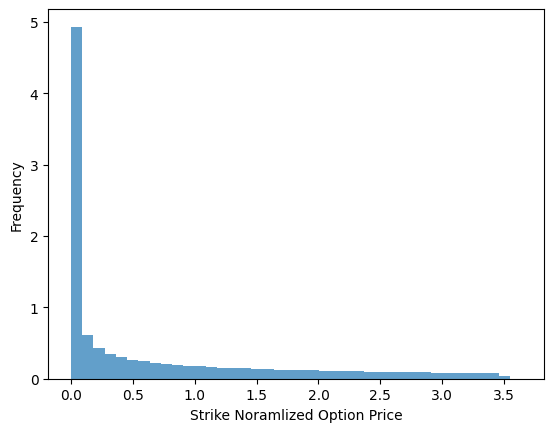

In [129]:
# plt frquency of strike normalized option price generated by sobol - BS Analystical Solution 
y_ck = y
plt.hist(y_ck, bins=40, density=True, alpha=0.7)
plt.xlabel("Strike Noramlized Option Price")
plt.ylabel("Frequency")

In [130]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

# Ensure y is 1D
y = y.squeeze()

X shape: torch.Size([262144, 3])
y shape: torch.Size([262144])
X dtype: torch.float32
y dtype: torch.float32


Thus we have more options which are worthless, meaning they finished OTM, which represents the real market conditions.

## Baseline and Gaussian Weighted Training (On Synthetic Blackscholes data)
We train 2 idential MLPs on the synthetic BlackScholes dataset:
1. **Baseline model:** minimized standard mean sqaured error over all samples 
2. **Gaussian-weighted (WMSE)** minimizes loss around ATM and Short datad options

This section trains two identical neural networks on the same synthetic dataset:
1. Baseline model trained with MSE.
2. Weighted model trained with WMSE.

We then compare overall error, error specifically on at the money options, and basic constraint diagnostics

#### Train Val Test Split 
- Random split for better optimization as the data is generated using sobol 
- Split 70:15:15

In [131]:
# Random split (Sobol is structured thus random split helps optimisation)
torch.manual_seed(42)

# 70:15:15; Train:Val:Test split 
n = len(X)
indices = torch.randperm(n)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

# create indx from the random sample 
train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

# use idx to create split 
# train 
x_train = X[train_idx]
y_train = y[train_idx]

# val
x_val = X[val_idx]
y_val = y[val_idx]

# test 
x_test = X[test_idx]
y_test = y[test_idx]

# split checks
print(indices[0])
print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

tensor(121958)
Train: 183500, Val: 39322, Test: 39322


#### Neural Net Design 
- A simple 3 layer feed forward network is choosen with 64 neurons and ELU activation for the Layer 1 and 2

In [132]:
# option neural network
# 3 layer simple feed forward network with ELU activation at layer 1 and 2 
class OptionPricer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(3, 64)
        self.activation = nn.ELU()
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

______________________________________

### Loss Function Design

We introduce a Gaussian kernel-based weighting scheme that prioritizes 
accuracy in economically important regions of the parameter space i.e. (Short dated and ATM Options) The 
weight assigned to each training sample is defined as:

$$w_i = \exp\left(-\frac{M_i^2}{2\lambda^2} - \beta T_i \right), \tag{1}$$

where $M_i$ represents the log-moneyness, $T_i$ is the time to maturity, 
$\lambda$ controls the width of the Gaussian kernel around at-the-money 
options, and $\beta$ governs the emphasis on near-expiry contracts.

Moneyness is a quadratic term which creates a symetric bell curve at M=0 that is ATM options, and decays equally for in-the-money and out-of-money options. The Time component is linerly penalized meaning meaning as we come closer to near expiry options the error are more penalized compared to the errors at long dated securities. 

The weighted mean squared error loss function is then given by:

$$L_{\text{WMSE}} = \frac{\sum_{i=1}^N w_i\, (y_i-\hat{y}_i)^2}{\sum_{i=1}^N w_i}, \tag{2}$$

where $y_i$ denotes the true option price and $\hat{y}_i$ is the neural 
network prediction. The denominator normalizes the weights to prevent 
biasing the overall loss magnitude.

For comparison, we also train a baseline model using the standard unweighted 
mean squared error:

$$L_{\text{MSE}} = \frac{1}{N}\sum_{i=1}^N (y_i-\hat{y}_i)^2 \tag{3}$$





#### Understanding Gaussian Loss Function
**Next 3 code blocks we will try to understand the behaviour of gaussian weighted loss function in terms of Moneyness and Time to Maturity**. The objective of the loss function is to penalize heavily on the ATM and Short-dated maturities for accuracy near the delta important region. 

Important Considerations:
1. Loss function must be smooth - so that the gradient does not get stuck in abrupt change 
2. Symmetric aroud ATM - so that delta of option changes symmetrically arround the mean (M=0), where $M=ln(S/K), note delta symmetrically decreases as option price moves away from the ATM (theoretically)
3. Weight must be bounded between $(0,1]$, i.e. $ 0 < w_i(M,T) < 1$ - this makes it meaningful for traing the neural net, the objectve is to have $w_i(0,T)=1$ - that is for a ATM, near expiry option the weight must be $\sim 1$

In [133]:
# defining weighted loss functionn 
def weight_function(M, T, lambda_m=1, beta=0.5):
    """
    Inputs
    M: moneyness (log(S/K) or S/K - 1)
    T: time to maturity
    lambda_m: bandwidth for moneyness Gaussian
    beta: decay rate for time
    
    Output 
    w_i: weights for the loss function 
    """
    M = np.asarray(M, dtype=float)         # vectorize M and T
    T = np.asarray(T, dtype=float)
    
    penalty_M = M**2 / (2 * lambda_m**2) # penalty for Moneyness error 
    penalty_T = beta * T                 # penalty for Time to Maturity 
    return np.exp(-penalty_M - penalty_T) # gaussian weighted loss function with exp-gaussian (penalty_m) and exp penalty on time
 
# Test single point
M_test= [0, 0, 1, -1.5, 1.5] 
T_test = [0, 0.8, 0, 2, 2] 

# weights 
w_test = weight_function(M_test, 
                         T_test,
                         lambda_m=1, 
                         beta=0.5)

for m, t, w in zip(M_test, T_test, w_test):
    print(f"M={m},T={t}: Weights={w:.6f}")
print("For ATM-ODTE Option Weights is one")

M=0,T=0: Weights=1.000000
M=0,T=0.8: Weights=0.670320
M=1,T=0: Weights=0.606531
M=-1.5,T=2: Weights=0.119433
M=1.5,T=2: Weights=0.119433
For ATM-ODTE Option Weights is one


#### 2d Weights Function 

0.0      0.472367     1.000000     0.703675     0.152397    
0.1      0.470011     0.995012     0.700166     0.151637    
0.5      0.416862     0.882497     0.620991     0.134490    
1.0      0.286505     0.606531     0.426801     0.092433    
1.5      0.153355     0.324652     0.228450     0.049476    


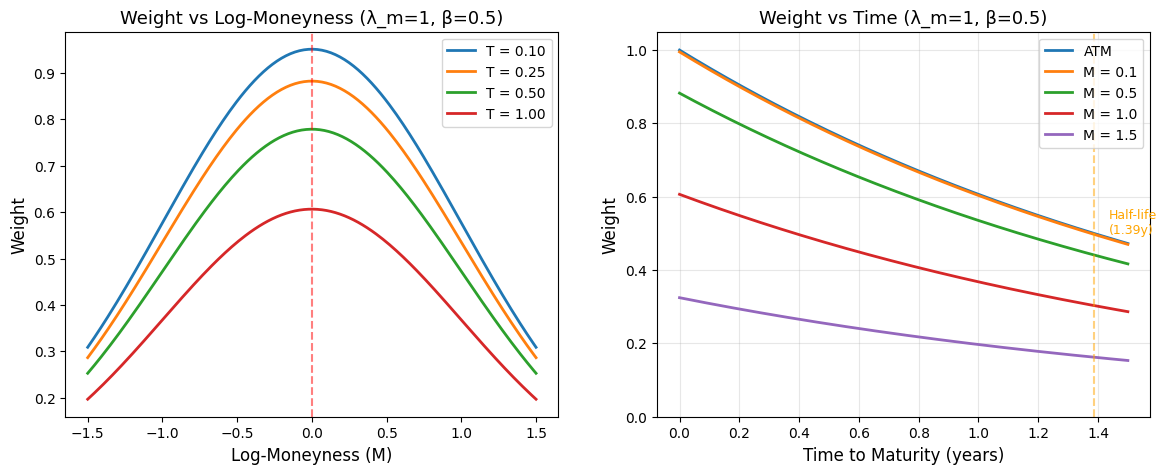

In [134]:
# Parameter
lambda_m = 1
beta = 0.5

# 1D Slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Weight vs Moneyness
M = np.linspace(-1.5, 1.5, 200)                              
for T in [0.1, 0.25, 0.5, 1.0]:                              # for all Time to maturity 
    w = weight_function(M, T, lambda_m, beta)
    ax1.plot(M, w, label=f'T = {T:.2f}', linewidth=2)

ax1.axvline(0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Log-Moneyness (M)', fontsize=12)
ax1.set_ylabel('Weight', fontsize=12)
ax1.set_title(f'Weight vs Log-Moneyness (λ_m={lambda_m}, β={beta})', fontsize=13)
ax1.legend()
# Weight vs Time   
                   
T = np.linspace(0, 1.5, 200)
for M in [0.0, 0.1, 0.5, 1, 1.5]:
    w = weight_function(M, T, lambda_m, beta)
    print(f"{M:<8.1f} {w.min():<12.6f} {w.max():<12.6f} {w.mean():<12.6f} {w.std():<12.6f}")
    label = 'ATM' if M == 0 else f'M = {M:.1f}'
    ax2.plot(T, w, label=label, linewidth=2)

half_life = np.log(2) / beta
ax2.axvline(half_life, color='orange', linestyle='--', alpha=0.5)
ax2.text(half_life + 0.05, 0.5, f'Half-life\n({half_life:.2f}y)', 
         fontsize=9, color='orange')
ax2.set_xlabel('Time to Maturity (years)', fontsize=12)
ax2.set_ylabel('Weight', fontsize=12)
ax2.set_title(f'Weight vs Time (λ_m={lambda_m}, β={beta})', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1.05])
plt.show()



>Left:
>- The weights in the gaussian moneyness decreases smoothly and symmetrically when moved away from ATM (M=0)
>- The peak of the curve reduces as T increases, therefore the weights of the loss function increases as the option reaches near-expiry. 
>- the weights decay is controled by lambda_m which controls the width of the curve 

>Right:
>- Weights decreases monotonically with increase in Time to Maturity, focusing on short dated maturities
>- Decay is smooth, controlled by time decay parameter $\beta$ 

##### Gaussian Loss Weights Visualization: Heat Map

/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_60084/2113950392.py:24: UserWarning: Adding colorbar to a different Figure <Figure size 800x500 with 2 Axes> than <Figure size 800x500 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=ax, label='Weight')


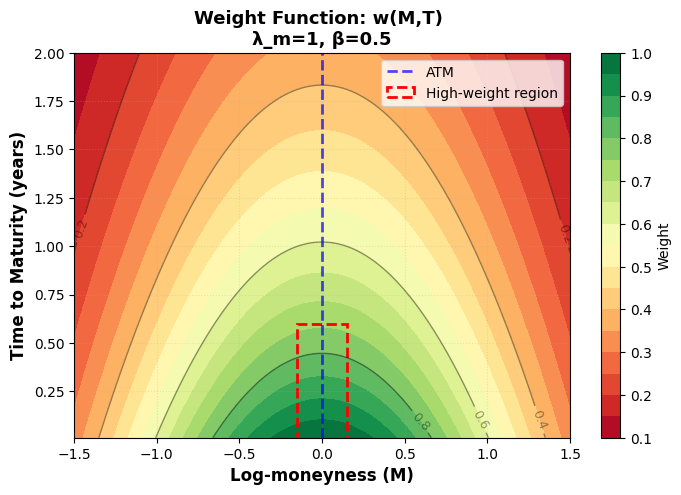

<Figure size 800x500 with 0 Axes>

In [135]:
# Heatmap
fig, ax = plt.subplots(figsize=(8, 5))

# Create grid
M = np.linspace(-1.5, 1.5, 150)
T = np.linspace(0.01, 2, 150)
M_grid, T_grid = np.meshgrid(M, T)
W = weight_function(M_grid, T_grid, lambda_m, beta)

# plt heatmap
im = ax.contourf(M_grid, T_grid, W, levels=20, cmap='RdYlGn')
cs = ax.contour(M_grid, T_grid, W, levels=[0.2, 0.4, 0.6, 0.8], 
                colors='black', linewidths=1, alpha=0.4)
ax.clabel(cs, inline=True, fontsize=9, fmt='%.1f')

# Mark ATM and priority region
ax.axvline(0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='ATM')
rect = plt.Rectangle((-0.15, 0), 0.3, 0.6, fill=False, edgecolor='red', 
                     linewidth=2, linestyle='--', label='High-weight region')
ax.add_patch(rect)

# Style
plt.figure(figsize=(8,5))
plt.colorbar(im, ax=ax, label='Weight')
ax.set_xlabel('Log-moneyness (M)', fontsize=12, fontweight='bold')
ax.set_ylabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
ax.set_title(f'Weight Function: w(M,T) \nλ_m={lambda_m}, β={beta}',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3, linestyle=':')
plt.tight_layout()
plt.savefig('weight_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

______________________________________________

## Model Training using Gaussian Weighted Loss Function 

In [136]:
# hyperparameters  
lambda_m = 1                 # increase to increase the width of the moneyness focus 
beta = 0.5                  # increase to focus on short term maturities 
 
# gaussian moneyness and time weights:                          w_i(M,T)
def gaussian_time_weights(x, lambda_m=0.25, beta=2.0):
    M = x[:, 0]        
    T = x[:, 1]                     
    w = torch.exp(-(M**2) / (2 * lambda_m**2) - beta * T)        
    return w

# normalized weighed mse : 1/n ∑ w_i(y - ycap)^2 / ∑ w_i
def weighted_mse(predictions, targets, weights):                           
    squared_errors = (targets - predictions) ** 2
    return torch.sum(weights * squared_errors) / torch.sum(weights)


In [137]:
# comptue weights for the train/val/test
weights_train = gaussian_time_weights(x_train, lambda_m=lambda_m, beta=beta)
weights_val   = gaussian_time_weights(x_val,   lambda_m=lambda_m, beta=beta)
weights_test  = gaussian_time_weights(x_test,  lambda_m=lambda_m, beta=beta)

print("Train weights:",
      f"min={weights_train.min().item():.4e},",
      f"max={weights_train.max().item():.4e},",
      f"mean={weights_train.mean().item():.4e},",
      f"median={weights_train.median().item():.4e}")

# diagnosis 
print(type(x_train), type(x_train[0,0]))

Train weights: min=1.1992e-01, max=9.9493e-01, mean=5.2675e-01, median=4.9496e-01
<class 'torch.Tensor'> <class 'torch.Tensor'>


#### Baseline MSE MODEL (MSE)

##### ADAM Optimizer 
For each parameter w:
Maintain running averages:
- m = β1 × m + (1-β1) × grad            # Momentum
- v = β2 × v + (1-β2) × (grad)**2       # Variance

Update:
w = w - lr × m / (√v + ε)

Benefits:
- Faster than SGD
- Adapts learning rate per parameter
- Less sensitive to lr choice

In [138]:
# training baseline MSE Model 
EPOCHS = 1000
LR = 1e-3

# loss 
train_losses = []
val_losses = []

torch.manual_seed(42)
model_mse = OptionPricer()
opt_mse = torch.optim.Adam(model_mse.parameters(), lr=LR)
mse_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    model_mse.train()
    pred = model_mse(x_train).squeeze()         
    loss = mse_loss(pred, y_train)

    opt_mse.zero_grad()
    loss.backward()
    opt_mse.step()
    
    train_losses.append(loss.item())
    
    
    model_mse.eval()
    with torch.no_grad():
        val_pred = model_mse(x_val).squeeze()
        val_loss = mse_loss(val_pred, y_val)
        val_losses.append(val_loss.item())
    print(f"[MSE]  Epoch {epoch:4d} | Train={loss.item():.6f} | Val={val_loss.item():.6f}")

[MSE]  Epoch    0 | Train=1.492273 | Val=1.350636
[MSE]  Epoch    1 | Train=1.336076 | Val=1.208844
[MSE]  Epoch    2 | Train=1.195809 | Val=1.082549
[MSE]  Epoch    3 | Train=1.070945 | Val=0.970824
[MSE]  Epoch    4 | Train=0.960553 | Val=0.872483
[MSE]  Epoch    5 | Train=0.863447 | Val=0.786307
[MSE]  Epoch    6 | Train=0.778411 | Val=0.711085
[MSE]  Epoch    7 | Train=0.704237 | Val=0.645584
[MSE]  Epoch    8 | Train=0.639693 | Val=0.588557
[MSE]  Epoch    9 | Train=0.583532 | Val=0.538788
[MSE]  Epoch   10 | Train=0.534542 | Val=0.495162
[MSE]  Epoch   11 | Train=0.491610 | Val=0.456728
[MSE]  Epoch   12 | Train=0.453792 | Val=0.422762
[MSE]  Epoch   13 | Train=0.420367 | Val=0.392778
[MSE]  Epoch   14 | Train=0.390858 | Val=0.366520
[MSE]  Epoch   15 | Train=0.365014 | Val=0.343918
[MSE]  Epoch   16 | Train=0.342771 | Val=0.325021
[MSE]  Epoch   17 | Train=0.324186 | Val=0.309916
[MSE]  Epoch   18 | Train=0.309352 | Val=0.298644
[MSE]  Epoch   19 | Train=0.298315 | Val=0.291118


#### Weighted MSE Model (WMSE)

In [139]:
# training weighted WMSE Model
torch.manual_seed(42)
model_wmse = OptionPricer()
opt_wmse = torch.optim.Adam(model_wmse.parameters(), lr=LR)

wmse_train_losses = []
wmse_val_losses = []

for epoch in range(EPOCHS):                                # full batch training; change to smaller batches later
    model_wmse.train()
    pred = model_wmse(x_train).squeeze()
    loss = weighted_mse(pred, y_train, weights_train)       # using the precalculated weigthed loss 

    opt_wmse.zero_grad()                                   # clean the gradients from the previous batch 
    loss.backward()                                        # gradients computation with the weighted loss 
    opt_wmse.step()                                        # weights are updated based on the weighted gradients 
    wmse_train_losses.append(loss.item())

 
    model_wmse.eval()                                        
    with torch.no_grad():
        val_pred = model_wmse(x_val).squeeze()                                   # forward pass for val 
        val_loss = weighted_mse(val_pred, y_val, weights_val)                    # calcualte loss 
        wmse_val_losses.append(val_loss.item())
    print(f"[WMSE]  Epoch {epoch:4d} | Train={loss.item():.6f} | Val={val_loss.item():.6f}")


[WMSE]  Epoch    0 | Train=1.003754 | Val=0.897660
[WMSE]  Epoch    1 | Train=0.889203 | Val=0.796532
[WMSE]  Epoch    2 | Train=0.789039 | Val=0.709194
[WMSE]  Epoch    3 | Train=0.702616 | Val=0.634425
[WMSE]  Epoch    4 | Train=0.628709 | Val=0.570839
[WMSE]  Epoch    5 | Train=0.565931 | Val=0.516941
[WMSE]  Epoch    6 | Train=0.512786 | Val=0.471155
[WMSE]  Epoch    7 | Train=0.467691 | Val=0.431892
[WMSE]  Epoch    8 | Train=0.429056 | Val=0.397692
[WMSE]  Epoch    9 | Train=0.395415 | Val=0.367352
[WMSE]  Epoch   10 | Train=0.365566 | Val=0.340021
[WMSE]  Epoch   11 | Train=0.338655 | Val=0.315218
[WMSE]  Epoch   12 | Train=0.314203 | Val=0.292792
[WMSE]  Epoch   13 | Train=0.292062 | Val=0.272847
[WMSE]  Epoch   14 | Train=0.272339 | Val=0.255637
[WMSE]  Epoch   15 | Train=0.255295 | Val=0.241464
[WMSE]  Epoch   16 | Train=0.241235 | Val=0.230568
[WMSE]  Epoch   17 | Train=0.230408 | Val=0.223035
[WMSE]  Epoch   18 | Train=0.222908 | Val=0.218726
[WMSE]  Epoch   19 | Train=0.21

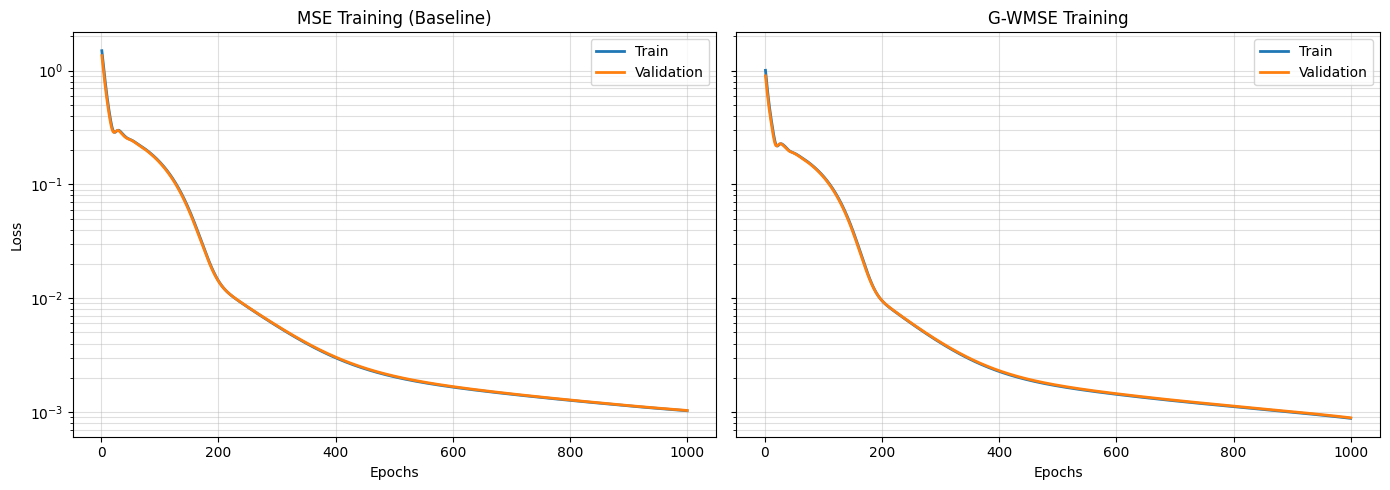

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# MSE
epochs_mse = np.arange(1, len(train_losses) + 1)
axes[0].plot(epochs_mse, train_losses, label="Train", linewidth=2)
axes[0].plot(epochs_mse, val_losses, label="Validation", linewidth=2)
axes[0].set_title("MSE Training (Baseline)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, which="both", alpha=0.4)

# WMSE
epochs_wmse = np.arange(1, len(wmse_train_losses) + 1)
axes[1].plot(epochs_wmse, wmse_train_losses, label="Train", linewidth=2)
axes[1].plot(epochs_wmse, wmse_val_losses, label="Validation", linewidth=2)
axes[1].set_title("G-WMSE Training")
axes[1].set_xlabel("Epochs")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].grid(True, which="both", alpha=0.4)

plt.tight_layout()
plt.show()

>Both objectives exibits stable and smooth convergence with nearly identical loss trajectories across full training horizon. Training and validation curves remian closely aligned in both the cases indicating no overfitting. Moreover this indicates that Gaussain sample weights in loss doesnot materially cause any numerical instability or convergence issues. Since the weighting scheme is smooth, bounded and strictly positive it preserves the well behaved optimization lanscape of the sqaured error loss.

#### Compute predictions on Test Sets 

In [141]:
# test set evaluation 
def evaluate_model(model, x, y, weights, model_name='Model'):   # weights w_i(M,T) are required for wmse calcualtions 
    model.eval()                                               # deactivates dropuout and batchnorm during inference                             
    with torch.no_grad():                                      # no gradient calculation for the code block, for memory and fast inference 
        pred = model(x).squeeze()
        
        
        # evaluation metrics 
        mse = nn.MSELoss()(pred, y).item()
        mae = torch.mean(torch.abs(pred - y)).item()
        rmse = np.sqrt(mse)            
        eps = 1e-8                                                # to avoid not defined results for the MAPE E[y-ycap/y]
        mape = torch.mean(torch.abs((pred - y) / (y.abs() + eps))).item()
        
        
        # weighted metrics 
        wmse = weighted_mse(pred, y, weights).item()               # weighte mse  
        
        
        # ATM metrics (M < 0.05)
        M = x[:, 0] 
        atm_mask = torch.abs(M) < 0.05 
        
        
        # check if atm sample greater than 0
        if atm_mask.sum() > 0:
            atm_mse = nn.MSELoss()(pred[atm_mask], y[atm_mask]).item()
            atm_mae = torch.mean(torch.abs(pred[atm_mask] - y[atm_mask])).item()
            atm_rmse = np.sqrt(atm_mse)
            atm_mape = torch.mean(torch.abs((pred[atm_mask] - y[atm_mask]) / y[atm_mask])).item()
        else:
            atm_mse = atm_mae = atm_rmse = atm_mape = float('nan')         
            
        # short dated - ATM options are evaluatee seperately to check the objective function performance
        # and compare high gamma and hedging sensetive region 
        # ATM-short dated matrics 
        T = x[:, 1]
        short_atm_mask = (torch.abs(M) < 0.05) & (torch.abs(T) < 0.04)                              # near atm and 15 days to expiry
        if short_atm_mask.sum() > 0:
            short_atm_mse = nn.MSELoss()(pred[short_atm_mask], y[short_atm_mask]).item()
            short_atm_rmse = np.sqrt(short_atm_mse)
            short_atm_mae = torch.mean(torch.abs(pred[short_atm_mask] - y[short_atm_mask])).item()
        else:
            short_atm_mse = short_atm_rmse = short_atm_mae = float('nan')
        
    # result dict 
    results = {
        'model': model_name,
        'overall_mse': mse,
        'overall_rmse': rmse,
        'overall_mae': mae,
        'overall_mape': mape,
        'weighted_mse': wmse,
        'atm_mse': atm_mse,
        'atm_rmse': atm_rmse,
        'atm_mae': atm_mae,
        'atm_mape': atm_mape,
        'short_atm_mse': short_atm_mse,
        'short_atm_rmse': short_atm_rmse,
        'atm_samples': atm_mask.sum().item(),
        'short_atm_samples': short_atm_mask.sum().item(),
        'short_atm_mae': short_atm_mae
    }
    
    return results, pred.cpu().numpy() # convert to numpy array for plots

In [142]:
mse_results, mse_pred = evaluate_model(model_mse, x_test, y_test, weights_test, "MSE")
wmse_results, wmse_pred = evaluate_model(model_wmse, x_test, y_test, weights_test, "WMSE")

df_results = pd.DataFrame([mse_results, wmse_results])
df_results.set_index("model")

,overall_mse,overall_rmse,overall_mae,overall_mape,weighted_mse,atm_mse,atm_rmse,atm_mae,atm_mape,short_atm_mse,short_atm_rmse,atm_samples,short_atm_samples,short_atm_mae
model,,,,,,,,,,,,,,
MSE,0.001010,0.031786,0.025545,371598.71875,0.001080,0.003192,0.056497,0.046861,575.318420,0.009958,0.099789,1312,84,0.099512
WMSE,0.000974,0.031208,0.024289,404298.03125,0.000866,0.002041,0.045182,0.036726,506.025818,0.006492,0.080575,1312,84,0.080296


In [143]:
# percentage 
 
delta_mse = (wmse_results['overall_mse'] - mse_results['overall_mse']) / mse_results['overall_mse'] * 100
print(f" Delta Overall MSE: {delta_mse:.4f}")

delta_mae = (wmse_results['overall_mae'] - mse_results['overall_mae']) / mse_results['overall_mae'] * 100
print(f" Delta Overall MAE: {delta_mae:.4f}")

delta_rmse = (wmse_results['overall_rmse'] - mse_results['overall_rmse']) / mse_results['overall_rmse'] * 100
print(f" Delta Overall RMSE: {delta_rmse:.4f}")

delta_atm_mae = (wmse_results['atm_mae'] - mse_results['atm_mae']) / mse_results['atm_mae'] * 100
print(f" Delta ATM MAE: {delta_atm_mae:.4f}")

delta_atm_rmse = (wmse_results['atm_rmse'] - mse_results['atm_rmse']) / mse_results['atm_rmse'] * 100
print(f" Delta ATM RMSE: {delta_atm_rmse:.4f}")

delta_atm_mse = (wmse_results['atm_mse'] - mse_results['atm_mse']) / mse_results['atm_mse'] * 100
print(f" Delta ATM MSE: {delta_atm_mse:.4f}")

delta_short_atm_mse = (wmse_results['short_atm_mse'] - mse_results['short_atm_mse']) / mse_results['short_atm_mse'] * 100
print(f" Short ATM MSE: {delta_short_atm_mse:.4f}")

delta_short_atm_rmse = (wmse_results['short_atm_rmse'] - mse_results['short_atm_rmse']) / mse_results['short_atm_rmse'] * 100
print(f" Short ATM RMSE: {delta_atm_rmse:.4f}")

delta_short_atm_mae = (wmse_results['short_atm_mae'] - mse_results['short_atm_mae']) / mse_results['short_atm_mae'] * 100
print(f" Short ATM MAE: {delta_short_atm_mae:.4f}")

 Delta Overall MSE: -3.6056
 Delta Overall MAE: -4.9186
 Delta Overall RMSE: -1.8194
 Delta ATM MAE: -21.6283
 Delta ATM RMSE: -20.0266
 Delta ATM MSE: -36.0426
 Short ATM MSE: -34.8022
 Short ATM RMSE: -20.0266
 Short ATM MAE: -19.3099


### Evaluation 
- WMSE performs slightly better in overall fit
- WMSE performs very good when only compared in ATM-Short Dated option 

Hence, we can cofidently say that, Weighted MSE performs better as overall model as well as gives strong performance in the economicly significant region.

Additionally, even after using the small eps for the numerical stability for MAPE, they are ill-poised for the out-of-money errors and doesnot provide any robust comparision

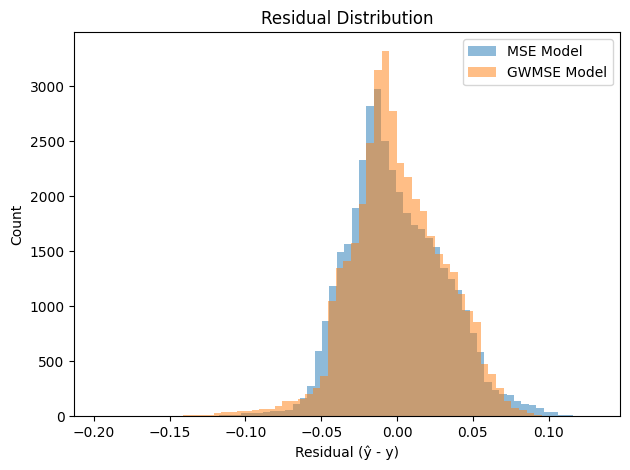

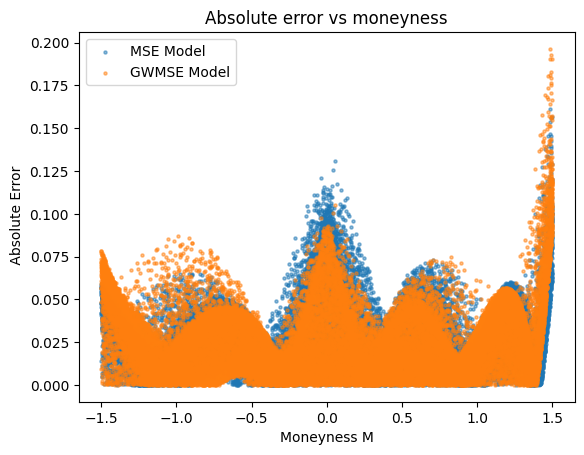

In [144]:
# Scatter plot for moneyness error 
# detach to break the graph; prevents memory leak during plotting 
# detach has shared memory so donont modify inplace 
y_true = y_test.detach().cpu().numpy().squeeze()
pred_mse = mse_pred.squeeze()
pred_wmse = wmse_pred.squeeze()
res_mse = pred_mse - y_true
res_wmse = pred_wmse - y_true

plt.figure()
plt.hist(res_mse, bins=60, alpha=0.5, label="MSE Model")
plt.hist(res_wmse, bins=60, alpha=0.5, label="GWMSE Model")
plt.xlabel("Residual (ŷ - y)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.legend()
plt.tight_layout()
plt.show()


x_np = x_test.detach().cpu().numpy()
M = x_np[:, 0]
T = x_np[:, 1]

abs_err_mse = np.abs(res_mse)
abs_err_wmse = np.abs(res_wmse)

plt.figure()
plt.scatter(M, abs_err_mse, s=5, alpha=0.5, label="MSE Model")
plt.scatter(M, abs_err_wmse, s=5, alpha=0.5, label="GWMSE Model")
plt.xlabel("Moneyness M")
plt.ylabel(" Absolute Error")
plt.title("Absolute error vs moneyness")
plt.legend()
plt.show()

> **Residual Distribution**:
> - Residual Distrubution suggests that both MSE and WMSE Models are centered around zero (slightly negative), and hence both are unbiased. This confirms that using WMSE does not introduce any systematic bias in the model
> - WMSE Model has slighlty tighter distribution around mean which suggests that there is little variance reduction in predictions compared to MSE 
> - The residuals are following gaussian distribution and donot have any heavy tail and outliers
> - its important to note that a slight negative errors suggests that the model is undervalauing the option prices > 

> **Absolute Error based on Moneyness**
> - There is an evident reduction of error for ATM options 
> - However the error increeses at deep-in the money and deep- out of the money options; this tradeoff can be justified as deep-itm and deep-otm options are less liquid and have high bid-ask spreads. We can conclude that on synthetic data, the model behaves the way it is intended, focusing on ATM and short dated options without introducing significant bias (except for the deep-ITM -OTM options)

-------------------------------
CHECK Clear Experiment on Real data on 'NN_option_pricing_using_SPY'

# Exp on Market Data 

In [145]:
import pandas as pd
import numpy as np
from scipy.stats import norm, qmc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance
import datetime
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [146]:
import random
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [147]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [148]:
df_market = pd.read_csv("market_data.csv")
df_market.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'optionSymbol', 'expiration', 'dte',
       'intrinsicValue', 'extrinsicValue', 'strike', 'mid', 'underlyingPrice',
       'spot_price', 'snapshot_date', 'volume', 'inTheMoney', 't_ann', 'M',
       'VIX', 'C/K', 'C', 'pred_ck_mse', 'pred_ck_wmse', 'pred_mid_mse',
       'pred_mid_wmse', 'ATM', 'SHORT', 'ATM_x_SHORT', 'C_dollar'],
      dtype='object')

#### Loading, Cleaning and Feature Engineering
- Fetaure
    - `M`= log(S/K): Log moneyness 
    - `t_ann` = time to maturity annulized 
    - `sigma` = VIX is chosen as a proxy, if VIX is not available then constant Vol = 0.20 
      - IV is avoided to avoid circularity  
- Traget 
    - `y_{c/k}`= `mid`/`Strike` (Normalized Call price by Strike price)

In [149]:
CSV_PATH = "market_data.csv"
df = pd.read_csv(CSV_PATH)

# Check required columns exist
req = ["snapshot_date", "t_ann", "M", "mid", "strike"]

# parsing date 
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
df = df[df["snapshot_date"].notna()].copy()

# Clean data
df = df[np.isfinite(df[["t_ann","M","mid","strike"]]).all(axis=1)].copy()
df = df[(df["t_ann"] > 0) & (df["strike"] > 0) & (df["mid"] >= 0)].copy()

# Create target: C/K
df["y_ck"] = (df["mid"] / df["strike"]).astype(np.float32)

##### Data Check
We enforce basic financial and numerical sanity checks prior to model training. Time-to-maturity (t_ann) is required to be strictly positive to avoid degenerate contracts. All model inputs (M, t_ann, VIX) are constrained to be finite, excluding missing or infinite values that would destabilize optimization. Option strikes are restricted to positive values, and observed mid-prices are constrained to be non-negative, consistent with no-arbitrage bounds. These assertions ensure numerical stability and economic validity of the training dataset.

In [150]:
# assert 
assert (df_market["t_ann"] > 0).all()
assert np.isfinite(df_market[["M", "t_ann", "VIX"]]).all().all(), "NaNs or infs in X"
assert (df_market["strike"] > 0).all(), "Invalid strikes"
assert (df_market["mid"] >= 0).all(), "Negative prices"            
  
# target variable 
df_market["C/K"] = df_market["mid"] / df_market["strike"]
df_market["C_dollar"] = df_market["mid"]

In [151]:
def pick_sigma(df):
    if "VIX" in df.columns and np.isfinite(df["VIX"]).mean() > 0.99:
        return "VIX"
    df["sigma_proxy"] = 0.20
    return "sigma_proxy"

sigma_col = pick_sigma(df)

#### Train:Test Split: Time based split 
- sorted by dates 
- first 80% dates for training 
- last 20% for testing


In [152]:
dates = np.array(sorted(df["snapshot_date"].unique()))
if len(dates) < 5:
    raise ValueError(f"Need more unique dates for time split, got {len(dates)}")


# 80:20
split = int(0.8 * len(dates))
train_dates = set(dates[:split])
test_dates  = set(dates[split:])


# split base on time 
train_df = df[df["snapshot_date"].isin(train_dates)].copy()
test_df  = df[df["snapshot_date"].isin(test_dates)].copy()

print(f"Unique dates: {len(dates)} | Train dates: {len(train_dates)} | Test dates: {len(test_dates)}")
print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")

Unique dates: 195 | Train dates: 156 | Test dates: 39
Train rows: 38065 | Test rows: 9958


#### Gaussian weighted loss function calcualtion for the real data 

In [153]:
# # weights implementation
# def gaussian_weights(df, lam=1, beta=0.5, M_col="M", T_col="t_ann", normalize_mean=True):
#     M = df[M_col].astype(float).to_numpy()
#     T = df[T_col].astype(float).to_numpy()
    
#     # weights
#     w = np.exp(-(M**2) / (2.0 * lam**2) - beta * T).astype(np.float32)
#     w = np.clip(w, 1e-4, None)        #  prevents zero-weight underflow
#     w = w / (np.mean(w) + 1e-8)
    
#     # Normalize weights to mean=1
#     if normalize_mean:
#         w = w / (np.mean(w) + 1e-8)
    
#     return w

def gaussian_weights(
    df,
    lam=0.4,              # wider ATM band
    beta=5.0,             # much softer time decay
    M_col="M",
    T_col="t_ann",
    normalize_mean=True,
    w_floor_itm=0.05      # << NEW
):
    M = df[M_col].to_numpy(float)
    T = df[T_col].to_numpy(float)

    w = np.exp(-(M**2)/(2*lam**2) - beta*T)

    # region-aware floor
    itM = M > 0.05
    w[itM] = np.maximum(w[itM], w_floor_itm)

    w = w.astype(np.float32)
    w /= (np.mean(w) + 1e-8)

    if normalize_mean:
        w /= (np.mean(w) + 1e-8)

    return w


#### Hyperparameter Lambda and Beta 

In [154]:
LAMBDA = 0.4   # lambda (log-moneyness width) 
BETA   = 5.0   # beta (time penalty rate)
ALPHA = 0.9


w_train = gaussian_weights(train_df, 
                           lam=LAMBDA, 
                           beta=BETA)
w_test  = gaussian_weights(test_df,  
                           lam=LAMBDA, 
                           beta=BETA)


# chceck tarin weights
print(f"Train weights: min={w_train.min():.4e}, max={w_train.max():.4e}, mean={w_train.mean():.4f}, median={np.median(w_train):.4f}")

Train weights: min=6.5763e-02, max=1.2974e+00, mean=1.0000, median=1.0838


#### Feature Engineering 
#### Z-Score Standardization
The scale and distribution of the inputs are heterogeous and hence required standardization for numerical stability and gradient scaling. Therefore Z-score scaling has been used with the following properties:
- compute the mu and sigma on training data, and freeze it to avoid lookahead bias 
- apply the same transformation on the test data 
$$\hat x_{test} = \frac{x_{test} - \mu_{train}}{\sigma_{train}}$$

In [155]:
FEATURES = ["t_ann", "M", sigma_col]  # X=[T, logM, sigma]

# Input features 
X_train = train_df[FEATURES].to_numpy(np.float32)
X_test  = test_df[FEATURES].to_numpy(np.float32)

# target variables 
y_train = train_df["y_ck"].to_numpy(np.float32)                          
y_test  = test_df["y_ck"].to_numpy(np.float32)

# Compute mean/std on TRAIN only
mu = X_train.mean(axis=0)                                             
sd = X_train.std(axis=0)
sd = np.where(sd < 1e-8, 1.0, sd)

# Apply to both train and test 
# the mu and sigma are calulated on the training set only to avoid lookahead bias 
X_train_z = (X_train - mu) / sd
X_test_z  = (X_test  - mu) / sd

#### DataLoader with weights 
-  batching the dataset into batches for efficient trainig 
- using dataloader for bathcing 
- shuffle=True, training will be shuffled but (only on the training dataset)

PyTorch `DataLoader` is a utility class designed to simplify the load and iteration over the datset for training. It has various contraints for the batching, suffling and processing data. 
- Batching helps to reduce the memory footprint by leveraging parallel processing
- shuffling prevents the model to overfit to noise by shuffling the dataset on the learning, provides more stable training and avoid stucking in local minima 

In our code:
we are loading the whole dataset from the disk into ram (since dataset is small), converting it into tensor (it lives on RAM), then we `__getitem__` lazy, from the ram on the index i (all labels at i), this avoid making a copy on the ram for the shuffled data on the RAM. Which is abstracted by the the DataLoader class by pytorch

In [156]:
from torch.utils.data import Dataset, DataLoader

# Data loading and batching 
class OptionDataset(Dataset):
    def __init__(self, X, y, w):
        # convert into tensor 
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.w = torch.tensor(w, dtype=torch.float32)  # Weights 
    
    # length of data    
    def __len__(self):
        return len(self.X)
    
    # get each values at index i
    def __getitem__(self, i):                                         
        return self.X[i], self.y[i], self.w[i]
    

# batch training 
BATCH = 2048

train_ds = OptionDataset(X_train_z, y_train, w_train)
test_ds  = OptionDataset(X_test_z,  y_test,  w_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)        
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, drop_last=False)

#### Model Architecture 

In [157]:
# 17K param model same as above 
class MLP(nn.Module):
    def __init__(self, in_dim=3, hidden=(64, 64), dropout=0.0, use_softplus=True):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers.append(nn.Linear(d, h))
            layers.append(nn.ELU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = h  # update input dimension for next layer

        self.body = nn.Sequential(*layers)
        self.out = nn.Linear(d, 1)  # d is last hidden size
        self.softplus = nn.Softplus() if use_softplus else nn.Identity()

    def forward(self, x):
        x = self.body(x)
        x = self.out(x)
        x = self.softplus(x)        # enforces non-negative output
        return x


In [158]:
m = MLP(in_dim=3, hidden=(64,64), use_softplus=True)
xb = torch.randn(2048, 3)
print(m(xb).shape)  # should be torch.Size([2048, 1])


torch.Size([2048, 1])


##### Loss function design
- we are using the same example as we used in the synthetic dataset. 

In [159]:
def loss_mse(pred, y):
    return torch.mean((pred - y) ** 2)

def loss_wmse(pred, y, w):
    # wighted mse formula see equation*
    return torch.sum(w * (pred - y) ** 2) / torch.sum(w)

# Mixture Loss:  alpha*WMSE + (1-alpha)*MSE
def loss_mix(pred, y, w, alpha=0.7):
    mse  = torch.mean((pred - y) ** 2)
    wmse = torch.sum(w * (pred - y) ** 2) / (torch.sum(w) + 1e-8)
    return alpha * wmse + (1.0 - alpha) * mse

#### Training and Testing
- Outer Split: Split the data into 80:20 (train:test)
- inner split: Split train data into 90:10 (train:val) 
- keep test data completely out of sample 
- validation use early stopping and model selection without peeking the test 
______________________________

##### Helper functions 
1. inner split 
2. mask for inner split and validation 
3. feature selection and numpy extraction

#### Temporal Data Partitioning 
`inner_split_masks`: This function creates a temporal split on the data by sorting the date and hold out the future date for the validation

In [160]:
def inner_split_masks(train_df_,
                            date_col = "snapshot_date", 
                            frac_train=0.9
                            ):
    """_summary_
    Time-based split unique dates in the date column,
    prevents look ahead bias by construction 

    Returns:
        inner_mask and val_mask for the time based split for the training dataset 
    """
    # assert missing date col
    assert date_col in train_df_.columns, "Missing Date Column"
    
    # arrange chronologically and select the dates 
    dts = np.array(sorted(train_df_[date_col].unique()))
    
    # cut select the index max of training data, which we will use later for validation, 
    # this avoid look-ahead bias in the validation set 
    cut = max(1, int(frac_train * len(dts)))
    
    # return set for past and future dts for immutable faster lookup later 
    inner_train_dates = set(dts[:cut])
    val_dates = set(dts[cut:])
    
    # convert it into inner and val mask  
    inner_mask = train_df_[date_col].isin(inner_train_dates).to_numpy()
    val_mask   = train_df_[date_col].isin(val_dates).to_numpy()

    # safe assertion 
    assert inner_mask.shape == val_mask.shape                                                 # shape check 
    assert inner_mask.sum() > 0, "No rows in inner train split"                               # greater than 0 rows
    assert val_mask.sum() > 0, "No rows in val split"                                       
    assert not np.any(inner_mask & val_mask), "Overlap between inner train and val!"          # no overlap for look ahead bias in val

    return inner_mask, val_mask

#### Data preperation and Data Integrity 
- `extract_arrays`: extracts the feature and target columns and convert them into np.float32 for later use 
- `fit_zscore`: Explicitly calls the fit_zscore(X_inner) only on the training set and hence avoid *Data leakage* from the test dataset. For numerical robustness np.where(sd < eps) ensures that the there is 1 SD instead of NaN or Zero  



In [161]:
## Data Extraction and Numpy conversion
def extract_arrays(df_, 
                   feature_cols,
                   y_col="y_ck", 
                   dtype=np.float32):
    """_summary_

    Args:
        df_: training dataFrame 
        feature_cols: t_ann, M and sigma  
        y_col: Strike normalized Call price 
        dtype: Defaults to np.float32.

    Returns:
        X, y numpy arrays 
    """

# check if column exists in df
    assert all(c in df_.columns for c in feature_cols), f"Missing features: {feature_cols}"  
    assert y_col in df_.columns, f"Missing target col: {y_col}"  

    X = df_[feature_cols].to_numpy(dtype)
    y = df_[y_col].to_numpy(dtype)
    return X, y


# apply z-score for inner traing only 
def fit_zscore(X, eps=1e-8):   
    mu = X.mean(axis=0)
    sd = X.std(axis=0)
    sd = np.where(sd < eps, 1.0, sd)     # if feature has zero variance -> sd = 0 -> default to 1   
    return mu, sd

def apply_zscore(X, mu, sd):
    return (X - mu) / sd


# inner val loader and tensors 
def make_inner_val_loaders(
    train_df_,
    feature_cols,
    w_train_all,                 # weights aligned with train_df_ rows (same order)
    date_col="snapshot_date",
    frac_train=0.9,
    batch_size=2048  
):
    
    # masks
    inner_mask, val_mask = inner_split_masks(train_df_, 
                                                   date_col=date_col, 
                                                   frac_train=frac_train)

    # arrays
    X_all, y_all = extract_arrays(train_df_, 
                                  feature_cols, 
                                  y_col="y_ck")

    # split
    X_inner, y_inner, w_inner = X_all[inner_mask], y_all[inner_mask], w_train_all[inner_mask]
    X_val,   y_val,   w_val   = X_all[val_mask],   y_all[val_mask],   w_train_all[val_mask]

    # fit scaler on inner-train only - no lookahead into val  
    mu, sd = fit_zscore(X_inner)

    # the X_val and X_inner z score values are kept seperate 
    X_inner_z = apply_zscore(X_inner, mu, sd).astype(np.float32)       
    X_val_z   = apply_zscore(X_val,   mu, sd).astype(np.float32) 

    # generator seed
    g = torch.Generator()
    g.manual_seed(SEED)
    
    # datasets/loaders
    inner_ds = OptionDataset(X_inner_z, y_inner, w_inner)
    inner_loader = DataLoader(inner_ds, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last=False, 
                              generator=g)

    # val tensors
    X_val_t = torch.tensor(X_val_z, dtype=torch.float32, device=DEVICE)
    y_val_t = torch.tensor(y_val,   dtype=torch.float32, device=DEVICE)
    w_val_t = torch.tensor(w_val,   dtype=torch.float32, device=DEVICE)

    return inner_loader, (X_val_t, y_val_t, w_val_t), (mu, sd), (inner_mask, val_mask)

##### Training function for EPOCH and Loss Calcualtions
This function implements a single epoch training using opt=ADAM optimizer. During each iteration, loader from DataLoader provides the mini-batches of inputs (xb), targets (yb) and sample weights (wb). All tensor are passed to DEVICE. 

The objective is selected dynamically using the mode parameter:
1. 'mse': Mean squared error, treating all the error samples uniformly 
2. 'wmse': wighted mean square error with the ephasis on ATM-short dated options
3. 'mix': a convex combination of MSE and WMSE, controlled by a mixing coefficient alpha

Before backprop, gradients are cleared, setting graients to None. Epoch level loss is accumulated as a **sum of batch loss weighted by batch size** rather than averaging per-batch loss directly. This ensure partial batches are handled correctly and loss represent the true sample level avg loss across epochs. 

The function returns the avergae loss per observation for the epoch 

In [162]:
import copy
import torch
import torch.nn as nn

# training one EPOCH  
def train_one_epoch(model, loader, opt, mode="mse"): 
    model.train()                                          # set model to training            
    total_loss = 0.0                                       # total loss 
    n_obs = 0                                              # total no of observation in the batch

    for xb, yb, wb in loader:                              # chuck training from loader 
        xb = xb.to(DEVICE)                                     # laoder handles the shuffling of batch data         
        yb = yb.to(DEVICE)                                        # handles partial batches 
        wb = wb.to(DEVICE)

        pred = model(xb).squeeze(-1)

        if mode == "mse":                                     
            loss = loss_mse(pred, yb)
        elif mode == "wmse":
            loss = loss_wmse(pred, yb, wb)
        elif mode == "mix":
            loss = loss_mix(pred, yb, wb, alpha=ALPHA)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        opt.zero_grad(set_to_none=True)                       # Optimization 
        loss.backward()
        opt.step()

        bs = xb.shape[0]                                      # calcualte the batch size              
        total_loss += float(loss.item()) * bs                 # total loss = loss * batch size; convert tensor into -> float 
        n_obs += bs

    return total_loss / max(1, n_obs)                          # final loss = total loss / avg sample in epoch 

##### Loss Evaluation: MSE, WMSE and MIX model

In [163]:
# evaluation function for both methods 
@torch.no_grad()                                       # no grad for eval 
def eval_loss(model, 
              X_t, 
              y_t, 
              w_t, 
              mode="mse"):
    model.eval()
    pred = model(X_t).squeeze(-1)

    if mode == "mse":                                  # two models for comparision with different loss function
        return float(loss_mse(pred, y_t).item())
    elif mode == "wmse":                              
        return float(loss_wmse(pred, y_t, w_t).item())
    elif mode == "mix":
        return float(loss_mix(pred, y_t, w_t, alpha=ALPHA).item())
    else:
        raise ValueError(f"Unknown mode: {mode}")

##### Model Training and Early Stopping 
- this function uses the `model`, `inner_loader` (to load the batched data), `tain_one_epoch`, and `eval_loss`
- `model_train_ES` function loop over multiple EPOCH to train the model with early stopping, the early stopping condition is checked using the validation loss with a small tolerance to create a buffer for improvement in the model, the best model weights are then saved and loaded using the `state_dict` object (python dict), it returns model and best_val

In [164]:
# Training with early stopping 
def model_train_ES(
    model,
    inner_loader,
    val_pack,                 # (X_val_t, y_val_t, w_val_t)
    mode="mse",
    lr=1e-3,
    epochs=100,               
    patience=15,
    tol=1e-6,
    status_print=10
):

    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)   

    X_val_t, y_val_t, w_val_t = val_pack    # unpack
  
    best_val = float("inf")                 # best validation loss; initialize at inf 
    best_state = None                       # Model weights when best val was achieved
    bad = 0                                 # a counter for epochs without improvement in val 

    for ep in range(1, epochs + 1):          
        # for each epoch complete pass
        tr = train_one_epoch(model, 
                             inner_loader, 
                             opt, 
                             mode=mode)
        
        # for each epoch calculate eval loss 
        v  = eval_loss(model,                        
                       X_val_t, 
                       y_val_t, 
                       w_val_t, 
                       mode=mode)


        # Early stopping.                                        # if current loss < best_loss - tolerance\
        if v < best_val - tol:                                     # early stopping if no significant error 
            best_val = v                                            # update best val 
            best_state = copy.deepcopy(model.state_dict())          # to save the weights in the dataset
            bad = 0                                                   # for each epoch count the bad 
        else:
            bad += 1                                                # increment if no improvelement for the epoch

        if ep == 1 or ep % status_print == 0:
            print(f"[{mode.upper()}] ep {ep:3d} | train {tr:.6f} | val {best_val:.6f} | bad {bad}/{patience}")

        # if bad epoch > patience stop 
        if bad >= patience:
            break

    # restore the best model from the best epoch 
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val

#### Test Set Tensor Preparation 
- Standardization: Test features are standardized using the mean (mu) and standard deviation (sd) computed on the training set only.



In [165]:
# convert to tensors 
def make_test_tensors(test_df, 
                      feature_cols, 
                      mu, 
                      sd, 
                      w_test, 
                      y_col="y_ck"):
    # raw arrays
    X_test = test_df[feature_cols].to_numpy(np.float32)
    y_test = test_df[y_col].to_numpy(np.float32)

    # Standardize using taraing statistics - apply TRAIN-FIT scaler (mu, sd)
    X_test_z = ((X_test - mu) / sd).astype(np.float32)

    
    # create tensors 
    X_test_t = torch.tensor(X_test_z, 
                            dtype=torch.float32, 
                            device=DEVICE)              # to have consistent output after division we convert again to float32
    y_test_t = torch.tensor(y_test,   
                            dtype=torch.float32, 
                            device=DEVICE)
    w_test_t = torch.tensor(w_test,   
                            dtype=torch.float32, 
                            device=DEVICE)
    return X_test_t, y_test_t, w_test_t


#### Metrics and  Evaluation 
The module below provides a the metrics to compare the three models (MSE, WMSE and MIX objective function) to understand the performace on the MSE, WMSE, RMSE and MAE.

In [166]:
# Predict  
# model eval mode on MSE, WMSE, MAE, RMSE
@torch.no_grad()
def predict(model, X_t):
    model.eval()
    return model(X_t).squeeze(-1).detach().cpu().numpy()      # no gradients to numpy array 

# METRICS 
# MSE 
def mse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean((a - b) **2))

# WMSE 
def wmse(a, b, w):
    a = np.asarray(a)
    b = np.asarray(b)
    w = np.asarray(w)
    return float(np.sum(w * (a - b)**2) / np.sum(w))

# Metrics 
# rmse 
def rmse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.sqrt(np.mean((a - b) ** 2)))                # float gives better precision compared to np.float

# mae 
def mae(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return float(np.mean(np.abs(a - b)))        

# eval on the following metrics 
def eval_on_test(model, X_test_t, y_test_t, w_test_t):
    yhat = predict(model, X_test_t)
    ytrue = y_test_t.detach().cpu().numpy()

    # unwighted results 
    results = {
        "mse": mse(yhat, ytrue),
        "rmse": rmse(yhat, ytrue),
        "mae": mae(yhat, ytrue),
        "yhat_mean": float(np.mean(yhat)),
        "y_mean": float(np.mean(ytrue)),
    }
    
    # weighted result addition 
    if w_test_t is not None:
        w_test = w_test_t.detach().cpu().numpy()
        results["wmse"] = wmse(yhat, ytrue, w_test)
        
    return results

### Model Experiment: MSE vs WMSE vs MIX Model 
This is a controlled experiment for comparing only the objective function on the same architecture and same dataset with same initialization. The only difference is the objective function. 

This block constitutes a clean ablation study where:
- architecture and data are held constant,
- initialization is identical across models,
- training hyperparameters and early stopping rules are identical,
- and the only treatment variable is the loss function.

In [167]:
# inner/val loaders and scaler 
inner_loader, val_pack, (mu_in, sd_in), (inner_mask, val_mask) = make_inner_val_loaders(
                                                                        train_df,
                                                                        feature_cols=FEATURES,
                                                                        w_train_all=w_train,
                                                                        date_col="snapshot_date",
                                                                        frac_train=0.9,
                                                                        batch_size=BATCH
                                                                    )

# initialize models from identical weights - for comparision 
base = MLP(in_dim=len(FEATURES),                             # create a base state and use for MSE and G-WMSE Model and MIX Model  
           hidden=(64,64), 
           dropout=0.0).to(DEVICE)
base_state = copy.deepcopy(base.state_dict())


# MSE-MODEL
model_mse = MLP(in_dim=len(FEATURES),                 
                hidden=(64,64),                             
                dropout=0.0).to(DEVICE)
model_mse.load_state_dict(base_state)


# WMSE-MODEL
model_wmse = MLP(in_dim=len(FEATURES), 
                 hidden=(64,64), 
                 dropout=0.0).to(DEVICE)
model_wmse.load_state_dict(base_state)


# MIX-MODEL
model_mix = MLP(in_dim=len(FEATURES), 
                hidden=(64,64), 
                dropout=0.0).to(DEVICE)
model_mix.load_state_dict(base_state)


# train all three (same data, same init)
# mse loss
model_mse,  best_val_mse  = model_train_ES(model_mse,  
                                        inner_loader, 
                                        val_pack, 
                                        mode="mse",
                                        lr=1e-3, 
                                        epochs=300, 
                                        patience=15)


# wmse loss
model_wmse, best_val_wmse = model_train_ES(model_wmse, 
                                    inner_loader, 
                                    val_pack, 
                                    mode="wmse",
                                    lr=1e-3, 
                                    epochs=300, 
                                    patience=15)

# mix loss
model_mix, best_val_mix = model_train_ES(
    model_mix,
    inner_loader,
    val_pack,
    mode="mix",
    lr=1e-3,
    epochs=300,
    patience=15
)

print("Best val mse:", best_val_mse)
print("Best val wmse:", best_val_wmse)
print("Best val mix:", best_val_mix)


# build test tensors using the SAME mu/sd (mu_in, sd_in)
X_test_t, y_test_t, w_test_t = make_test_tensors(test_df, FEATURES, mu_in, sd_in, w_test, y_col="y_ck")

# evaluate on test
print("TEST MSE model:",  eval_on_test(model_mse,  X_test_t, y_test_t, w_test_t))
print("TEST WMSE model:", eval_on_test(model_wmse, X_test_t, y_test_t, w_test_t))
print("TEST MIX model:", eval_on_test(model_mix, X_test_t, y_test_t, w_test_t))

[MSE] ep   1 | train 0.180908 | val 0.045372 | bad 0/15
[MSE] ep  10 | train 0.002892 | val 0.002169 | bad 0/15
[MSE] ep  20 | train 0.001971 | val 0.001381 | bad 0/15
[MSE] ep  30 | train 0.001058 | val 0.000726 | bad 0/15
[MSE] ep  40 | train 0.000476 | val 0.000347 | bad 0/15
[MSE] ep  50 | train 0.000261 | val 0.000201 | bad 0/15
[MSE] ep  60 | train 0.000181 | val 0.000150 | bad 0/15
[MSE] ep  70 | train 0.000139 | val 0.000115 | bad 2/15
[MSE] ep  80 | train 0.000108 | val 0.000093 | bad 0/15
[MSE] ep  90 | train 0.000083 | val 0.000075 | bad 1/15
[MSE] ep 100 | train 0.000064 | val 0.000055 | bad 0/15
[MSE] ep 110 | train 0.000051 | val 0.000046 | bad 0/15
[MSE] ep 120 | train 0.000039 | val 0.000038 | bad 1/15
[MSE] ep 130 | train 0.000032 | val 0.000032 | bad 1/15
[MSE] ep 140 | train 0.000027 | val 0.000029 | bad 2/15
[MSE] ep 150 | train 0.000024 | val 0.000024 | bad 1/15
[MSE] ep 160 | train 0.000021 | val 0.000022 | bad 2/15
[MSE] ep 170 | train 0.000019 | val 0.000020 | b

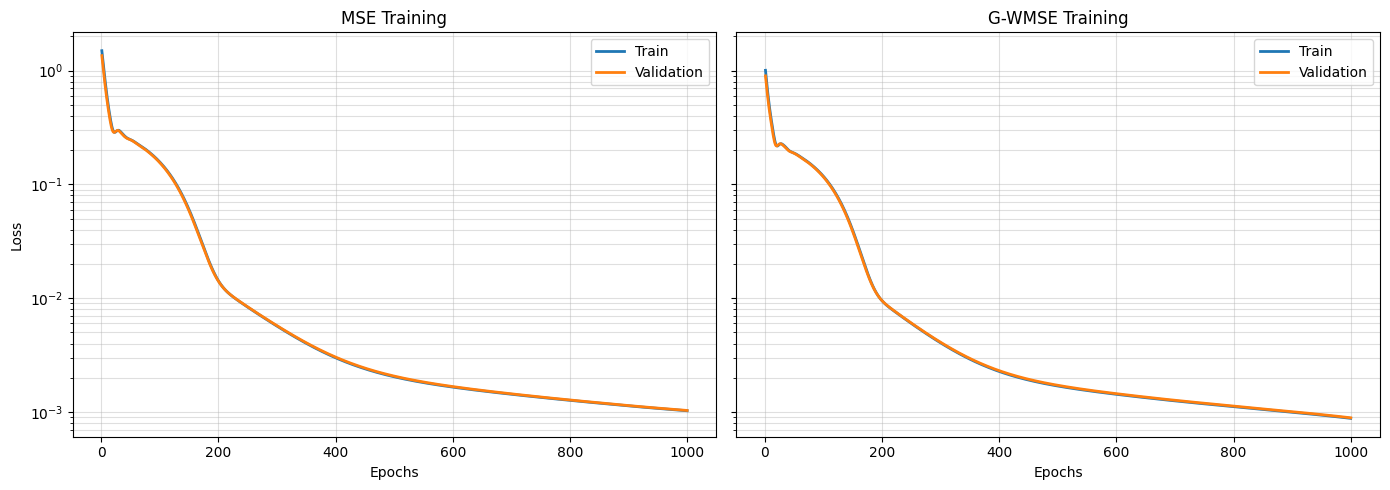

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# MSE
epochs_mse = np.arange(1, len(train_losses) + 1)
axes[0].plot(epochs_mse, train_losses, label="Train", linewidth=2)
axes[0].plot(epochs_mse, val_losses, label="Validation", linewidth=2)
axes[0].set_title("MSE Training")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].grid(True, which="both", alpha=0.4)

# WMSE
epochs_wmse = np.arange(1, len(wmse_train_losses) + 1)
axes[1].plot(epochs_wmse, wmse_train_losses, label="Train", linewidth=2)
axes[1].plot(epochs_wmse, wmse_val_losses, label="Validation", linewidth=2)
axes[1].set_title("G-WMSE Training")
axes[1].set_xlabel("Epochs")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].grid(True, which="both", alpha=0.4)

plt.tight_layout()
plt.show()

In [169]:
# Get predictions (already have this function)
@torch.no_grad()
def predict(model, X_t):
    model.eval()
    return model(X_t).squeeze(-1).detach().cpu().numpy()

# Predict with both models
pred_mse  = predict(model_mse,  X_test_t)
pred_wmse = predict(model_wmse, X_test_t)
pred_mix  = predict(model_mix,  X_test_t)   # <-- NEW

y_true = y_test_t.detach().cpu().numpy()


# Add to test dataframe for analysis
test_df['pred_mse'] = pred_mse
test_df['pred_wmse'] = pred_wmse
test_df['error_mse'] = np.abs(pred_mse - y_true)
test_df['error_wmse'] = np.abs(pred_wmse - y_true)
test_df['sq_error_mse'] = (pred_mse - y_true) ** 2
test_df['sq_error_wmse'] = (pred_wmse - y_true) ** 2

print(f"Shapes: {test_df.shape}")

Shapes: (9958, 34)


##### Checks: Negative Option Price
Since negative option price is violation of the option pricing, we check the role of `softplus` in the output layer which allows for strict non-negative call option pricing 

In [170]:
def neg_report(name, preds):
    n_neg = int((preds < 0).sum())
    print(f"{name}: {n_neg:,} negative predictions ({100*n_neg/len(preds):.2f}%)")

neg_report("MSE model",  pred_mse)
neg_report("WMSE model", pred_wmse)
neg_report("MIX model",  pred_mix)

MSE model: 0 negative predictions (0.00%)
WMSE model: 0 negative predictions (0.00%)
MIX model: 0 negative predictions (0.00%)


In [171]:
# predictions
out = test_df.copy()

out["pred_ck_mse"]  = pred_mse
out["pred_ck_wmse"] = pred_wmse
out["pred_ck_mix"]  = pred_mix              # mix

# errors
out["err_mse"]  = out["pred_ck_mse"]  - y_true
out["err_wmse"] = out["pred_ck_wmse"] - y_true
out["err_mix"]  = out["pred_ck_mix"]  - y_true   # mix

out["abs_err_mse"]  = np.abs(out["err_mse"])
out["abs_err_wmse"] = np.abs(out["err_wmse"])
out["abs_err_mix"]  = np.abs(out["err_mix"])     # mix

out["sq_error_mse"]  = out["err_mse"]**2
out["sq_error_wmse"] = out["err_wmse"]**2
out["sq_error_mix"]  = out["err_mix"]**2         # mix

out.to_csv("preds_test.csv", index=False)
print("Saved: preds_test.csv")


Saved: preds_test.csv


In [172]:
def wmse_metric(y, yhat, w):
    y = np.asarray(y); yhat = np.asarray(yhat); w = np.asarray(w)
    return float(np.sum(w * (y - yhat)**2) / (np.sum(w) + 1e-12))

w_test_raw = gaussian_weights(test_df, lam=LAMBDA, beta=BETA, normalize_mean=False)

print("\nTest weighted MSE metric:")
print("  MSE-model :",  wmse_metric(y_true, pred_mse,  w_test_raw))
print("  WMSE-model:",  wmse_metric(y_true, pred_wmse, w_test_raw))
print("  MIX-model :",  wmse_metric(y_true, pred_mix,  w_test_raw))


Test weighted MSE metric:
  MSE-model : 0.0042644524946808815
  WMSE-model: 0.005449829623103142
  MIX-model : 0.004881418310105801


We analyzes model performance across moneyness regimes, with a specific focus on the at-the-money (ATM) region, which is the most liquid and economically relevant part of the option surface.

The thresholds are chosen to:

- separate deep out-of-the-money and deep in-the-money tails,
- isolate a narrow ATM band around zero where pricing sensitivity (gamma) is highest,
- align with common practitioner heuristics rather than arbitrary percentiles.

In [173]:
def categorize_moneyness(M):
    if M < -0.5: return "Deep OTM"
    elif M < -0.05: return "OTM"
    elif M <= 0.05: return "ATM"
    elif M <= 0.5: return "ITM"
    else: return "Deep ITM"

out["moneyness_region"] = out["M"].apply(categorize_moneyness)
out["tradeable"] = (out["y_ck"] >= 0.001) & (out["y_ck"] < 1.0)

atm_mask = (out["M"].abs() < 0.05)

def atm_report(label, sq_err_col):
    rmse_val = float(np.sqrt(out.loc[atm_mask, sq_err_col].mean()))
    return rmse_val

atm_rmse_mse  = atm_report("MSE",  "sq_error_mse")
atm_rmse_wmse = atm_report("WMSE", "sq_error_wmse")
atm_rmse_mix  = atm_report("MIX",  "sq_error_mix")  

print("\nATM REGION (|M| < 0.05) Result:")
print(f"Samples: {int(atm_mask.sum()):,}")
print(f"RMSE (MSE):  {atm_rmse_mse:.6f}")
print(f"RMSE (WMSE): {atm_rmse_wmse:.6f}  | Improvement vs MSE: {100*(atm_rmse_mse-atm_rmse_wmse)/atm_rmse_mse:+.1f}%")
print(f"RMSE (MIX):  {atm_rmse_mix:.6f}   | Improvement vs MSE: {100*(atm_rmse_mse-atm_rmse_mix)/atm_rmse_mse:+.1f}%")



ATM REGION (|M| < 0.05) Result:
Samples: 2,620
RMSE (MSE):  0.005148
RMSE (WMSE): 0.004536  | Improvement vs MSE: +11.9%
RMSE (MIX):  0.004630   | Improvement vs MSE: +10.1%


In [174]:
def compare_by_region(df):
    rows = []
    for region in ["Deep OTM", "OTM", "ATM", "ITM", "Deep ITM"]:
        mask = (df["moneyness_region"] == region)
        n = int(mask.sum())
        if n == 0:
            continue

        rmse_mse  = float(np.sqrt(df.loc[mask, "sq_error_mse"].mean()))
        rmse_wmse = float(np.sqrt(df.loc[mask, "sq_error_wmse"].mean()))
        rmse_mix  = float(np.sqrt(df.loc[mask, "sq_error_mix"].mean()))

        rows.append({
            "Region": region,
            "n": n,
            "RMSE (MSE)":  rmse_mse,
            "RMSE (WMSE)": rmse_wmse,
            "RMSE (MIX)":  rmse_mix,
            "WMSE vs MSE %": 100.0 * (rmse_mse - rmse_wmse) / (rmse_mse + 1e-12),
            "MIX vs MSE %":  100.0 * (rmse_mse - rmse_mix)  / (rmse_mse + 1e-12),
        })

    return pd.DataFrame(rows)

print("PERFORMANCE BY REGION:")
reg_tab = compare_by_region(out)
print(reg_tab.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
out.to_csv("predictions_with_analysis.csv", index=False)

PERFORMANCE BY REGION:
  Region    n  RMSE (MSE)  RMSE (WMSE)  RMSE (MIX)  WMSE vs MSE %  MIX vs MSE %
Deep OTM  117 4.22858e-06  4.23052e-06 4.24125e-06     -0.0460385     -0.299761
     OTM 2189  0.00119561   0.00100817  0.00102842        15.6778       13.9838
     ATM 2620  0.00514805   0.00453563  0.00462966        11.8961       10.0696
     ITM 3421   0.0019234   0.00189587   0.0017868        1.43128       7.10209
Deep ITM 1611    0.599458     0.677983    0.641587       -13.0994      -7.02792


In [175]:
def overall_metrics(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mse  = float(np.mean((y - yhat)**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(y - yhat)))
    return {"mse": mse, "rmse": rmse, "mae": mae, "yhat_mean": float(np.mean(yhat)), "y_mean": float(np.mean(y))}

m_mse  = overall_metrics(y_true, pred_mse)
m_wmse = overall_metrics(y_true, pred_wmse)
m_mix  = overall_metrics(y_true, pred_mix)

summary = pd.DataFrame([m_mse, m_wmse, m_mix], index=["MSE-model", "WMSE-model", "MIX-model"])
summary["RMSE_impr_%_vs_MSE"] = 100.0 * (summary.loc["MSE-model","rmse"] - summary["rmse"]) / (summary.loc["MSE-model","rmse"] + 1e-12)
summary["MAE_impr_%_vs_MSE"]  = 100.0 * (summary.loc["MSE-model","mae"]  - summary["mae"])  / (summary.loc["MSE-model","mae"]  + 1e-12)

print("\nOVERALL TEST FIT:")
print(summary[["mse","rmse","mae","RMSE_impr_%_vs_MSE","MAE_impr_%_vs_MSE","yhat_mean","y_mean"]]
      .to_string(float_format=lambda x: f"{x:.6g}"))
summary.to_csv("overall_fit_3way.csv")



OVERALL TEST FIT:
                 mse     rmse       mae  RMSE_impr_%_vs_MSE  MAE_impr_%_vs_MSE  yhat_mean   y_mean
MSE-model   0.058144 0.241131 0.0221035                   0                  0   0.372878 0.391788
WMSE-model 0.0743707  0.27271 0.0259369            -13.0963           -17.3428   0.369558 0.391788
MIX-model  0.0666009 0.258072 0.0240708            -7.02565           -8.90028   0.370784 0.391788


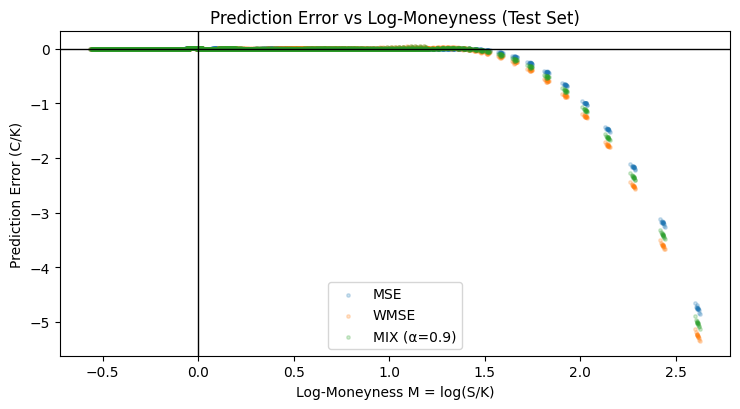

In [176]:
plt.figure(figsize=(7.5, 4.2))

plt.scatter(out["M"], out["err_mse"],  s=6, alpha=0.22, label="MSE")
plt.scatter(out["M"], out["err_wmse"], s=6, alpha=0.22, label="WMSE")
plt.scatter(out["M"], out["err_mix"],  s=6, alpha=0.22, label=f"MIX (α={ALPHA})")

plt.axhline(0, color="k", lw=1)
plt.axvline(0, color="k", lw=1)

plt.xlabel("Log-Moneyness M = log(S/K)")
plt.ylabel("Prediction Error (C/K)")
plt.title("Prediction Error vs Log-Moneyness (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


### Model Robustness Check 
no-arb diagnostic is checked on the test dataset, thus out of sample check. **This only include the tradable universe** which is T > 0.05 years, ultra-short dated options are highly sensetive to marketmicrostucture noise, wide bid-ask spread and discontinious pay-off behaviour near expiry. The stratification is done based on the moneyness where liquid universe is (M <= 0.2) which includes out-of-money, at-the-money and slightly in-the-money options, the deep-in-the-money options M (Log (S/K)) > 0.2 ~ 1.22 or 22% ITM  where the intrincic value dominates. 

#### No arb constrain 
For european call option, no-arb requires the option price to satisfy the lower bound 

$$C \geq max(S - K^{-rt}, 0)$$

meaning the option must be worth atleast its discounted intrinsic value, otherwise, a static arb opportunity exist. Prices are evaluated in normalized in C/K form as above. 

A lower-bound violation is recorded when the predicted normalized price falls below the theoretical bound by more than a numerical tolerance eps = 0.001, corresponding to $0.10 per $100 strike.This tolerance accounts for floating-point precision and is well within typical bid-ask spreads for SPY options. Market mid-prices are evaluated against the same no-arbitrage criterion and serve as a baseline. Due to **discretization** i.e. there can be small violation arising due to tick-size and use of mid quotes rather than executable price. Also microstructure effects (stale quotes, bid-ask spread due to liquidity), even observed market prices may exhibit occasional bound violations, providing a realistic benchmark for model performance.

In [177]:
#  tradable uni
# Tradeable options (exclude ultra-short maturity ~18 days)
tradeable = out[out["t_ann"] > 0.05].copy()

liquid   = tradeable[tradeable["M"] <= 0.2].copy()
deep_itm = tradeable[tradeable["M"] > 0.2].copy()

print(f"Tradeable options: {len(tradeable)}")
print(f"Liquid (M ≤ 0.2): {len(liquid)}")
print(f"Deep ITM (M > 0.2): {len(deep_itm)}")

# normalized bound 
def lower_bound_normalized(df, r=0.035):
    S_over_K = np.exp(df["M"].values)                          # European call lower bound (normalized):
    discount = np.exp(-r * df["t_ann"].values)                      # C/K ≥ max(S/K - e^{-rT}, 0)
    return np.maximum(S_over_K - discount, 0.0)                         # assuming 0.035 risk free interest rate 
                                                                
lb_liquid = lower_bound_normalized(liquid)
lb_deep   = lower_bound_normalized(deep_itm)

Tradeable options: 1032
Liquid (M ≤ 0.2): 746
Deep ITM (M > 0.2): 286


**70% option in the tradable universe**

In [178]:
# viloation
TOL = 0.001  # $0.10 per $100 strike

def violation_stats(df, preds, lower_bound):
    viol = preds < (lower_bound - TOL)
    return {
        "N": len(preds),
        "Violations (%)": 100 * viol.mean(),
        "MAE ($)": 100 * np.mean(np.abs(preds - df["y_ck"].values))
    }


# results 
models = [
    ("Market", "y_ck"),
    ("MSE",    "pred_ck_mse"),
    ("WMSE",   "pred_ck_wmse"),
    ("MIX",    "pred_ck_mix"),
]

results = []

# Liquid universe
for name, col in models:
    stats = violation_stats(liquid, liquid[col].values, lb_liquid)
    stats.update({"Universe": "Liquid (M≤0.2)", "Model": name})
    results.append(stats)

# Deep ITM universe
for name, col in models:
    stats = violation_stats(deep_itm, deep_itm[col].values, lb_deep)
    stats.update({"Universe": "Deep ITM (M>0.2)", "Model": name})
    results.append(stats)

results_df = pd.DataFrame(results)
print(results_df)


     N  Violations (%)   MAE ($)          Universe   Model
0  746        0.000000  0.000000    Liquid (M≤0.2)  Market
1  746        8.981233  0.211672    Liquid (M≤0.2)     MSE
2  746        0.000000  0.187989    Liquid (M≤0.2)    WMSE
3  746        0.000000  0.190553    Liquid (M≤0.2)     MIX
4  286        5.944056  0.000000  Deep ITM (M>0.2)  Market
5  286       31.468531  0.466583  Deep ITM (M>0.2)     MSE
6  286       33.216783  0.848416  Deep ITM (M>0.2)    WMSE
7  286       34.965035  0.700001  Deep ITM (M>0.2)     MIX


### Summary 
We evaluate the no-arb and MAE on the out of sample data. The analysis focuses on liquid call options $T > 0.05$ & $\, M \leq 0.2$ which consist of 70% of the test sample contracts. The MSE model violates the European call option lower bound by ~9%, whereas the proposed WMSE and Hybrid MIX model resulted into zero no-arb violation for the liquid options. 

However, in the deep-ITM (M>0.2) (where also model performance drops significantly -13% when WMSE compared to MSE and -11% for MIX compared to MSE), but there are 5% market violation of the lower bound rule suggesting discretization and market microstructure noise. 

In [ ]:
EPS_NORM = 0.001  # same tolerance in C/K units

def bounds_violations(df, price_col, r=0.035, eps=EPS_NORM):
    # Lower bound in normalized units: C/K >= max(S/K - exp(-rT), 0)
    S = df["spot_price"].values
    K = df["strike"].values
    T = df["t_ann"].values
    
    lb = np.maximum(S / K - np.exp(-r * T), 0.0)
    ub = S / K                                             # since C <= S  => C/K <= S/K
    
    p = df[price_col].values
    
    v_lb = p < (lb - eps)
    v_ub = p > (ub + eps)
    v_nn = p < (0.0 - eps)  # non-negativity
    
    return {
        "lb_rate": v_lb.mean(),
        "ub_rate": v_ub.mean(),
        "nn_rate": v_nn.mean(),
    }

def strike_monotone_convex(df, price_col, eps=EPS_NORM):
    # expects df is a single group: fixed snapshot_date + expiration (and calls)
    g = df.sort_values("strike")
    K = g["strike"].values.astype(float)
    C = g[price_col].values.astype(float)  # can be C/K or C; must be consistent
    
    if len(K) < 3:
        return {"mono_rate": np.nan, "conv_rate": np.nan, "n": len(K)}
    
    # Monotonicity: C(K_{i+1}) - C(K_i) <= eps
    dC = np.diff(C)
    mono_viol = dC > eps
    
    # Convexity on non-uniform grid via slope differences
    dK = np.diff(K)
    slopes = dC / dK
    dslopes = np.diff(slopes)
    conv_viol = dslopes < -eps  # allow small negative due to noise
    
    # Report pointwise rates (aligned to differences)
    mono_rate = mono_viol.mean() if len(mono_viol) else np.nan
    conv_rate = conv_viol.mean() if len(conv_viol) else np.nan
    
    return {"mono_rate": mono_rate, "conv_rate": conv_rate, "n": len(K)}

def static_arb_report(df, price_cols, group_cols=("snapshot_date","expiration"), r=0.035, eps=EPS_NORM):
    rows = []
    # group-level tests for monotonicity/convexity
    grouped = df.groupby(list(group_cols), sort=False)
    
    for model_name, col in price_cols.items():
        # bounds: pointwise over all rows
        b = bounds_violations(df, col, r=r, eps=eps)
        
        mono_rates = []
        conv_rates = []
        grp_sizes  = []
        
        for _, g in grouped:
            s = strike_monotone_convex(g, col, eps=eps)
            if np.isnan(s["mono_rate"]):  # skip small groups
                continue
            mono_rates.append(s["mono_rate"])
            conv_rates.append(s["conv_rate"])
            grp_sizes.append(s["n"])
        
        rows.append({
            "Model": model_name,
            "N_contracts": len(df),
            "N_groups": len(mono_rates),
            "LowerBoundViol%": 100*b["lb_rate"],
            "UpperBoundViol%": 100*b["ub_rate"],
            "NonNegViol%": 100*b["nn_rate"],
            "StrikeMonoViol%_avgGroup": 100*np.mean(mono_rates) if mono_rates else np.nan,
            "StrikeConvexViol%_avgGroup": 100*np.mean(conv_rates) if conv_rates else np.nan,
        })
    
    return pd.DataFrame(rows)

# Example usage:
tradeable = out[out["t_ann"] > 0.05].copy()

# calls only
if "side" in tradeable.columns:
    tradeable = tradeable[tradeable["side"].str.lower() == "call"].copy()

price_cols = {
    "Market": "y_ck",
    "MSE":    "pred_ck_mse",
    "WMSE":   "pred_ck_wmse",
    "MIX":    "pred_ck_mix",
}

report_all = static_arb_report(tradeable, price_cols, r=0.035, eps=EPS_NORM)
report_liq = static_arb_report(tradeable[tradeable["M"] <= 0.2], price_cols, r=0.035, eps=EPS_NORM)
report_dit = static_arb_report(tradeable[tradeable["M"] >  0.2], price_cols, r=0.035, eps=EPS_NORM)

print("ALL TRADEABLE")
print(report_all)
print("\nLIQUID (M<=0.2)")
print(report_liq)
print("\nDEEP ITM (M>0.2)")
print(report_dit)

ALL TRADEABLE
    Model  N_contracts  N_groups  LowerBoundViol%  UpperBoundViol%  \
0  Market         1032         4         1.647287              0.0   
1     MSE         1032         4        15.213178              0.0   
2    WMSE         1032         4         9.205426              0.0   
3     MIX         1032         4         9.689922              0.0   

   NonNegViol%  StrikeMonoViol%_avgGroup  StrikeConvexViol%_avgGroup  
0          0.0                       0.0                     0.78125  
1          0.0                       0.0                     0.00000  
2          0.0                       0.0                     0.00000  
3          0.0                       0.0                     0.00000  

LIQUID (M<=0.2)
    Model  N_contracts  N_groups  LowerBoundViol%  UpperBoundViol%  \
0  Market          746         4         0.000000              0.0   
1     MSE          746         4         8.981233              0.0   
2    WMSE          746         4         0.000000    